<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->

**CURSO DE PÓS-GRADUAÇÃO EM CIÊNCIA DE DADOS (BIG DATA PROCESSING AND ANALYTICS)**<p>
**Componente curricular:** VISUALIZAÇÃO DE DADOS PARA TOMADA DE DECISÃO [TURMA 01D] - 2023/1 - Trilha 6.<br>

**Aluno:** ROBSON DE FREITAS SAMPAIO.<br>

**URL deste notebook:** https://github.com/rfsampaio/postgraduate_data_science/blob/main/notebooks/VD_T6.ipynb<br>
***

#### **Para esta atividade, vamos explorar um dataset do Portal de Dados Abertos do "Programa Queimadas" do INPE, disponível em [https://queimadas.dgi.inpe.br/queimadas/dados-abertos/#](https://queimadas.dgi.inpe.br/queimadas/dados-abertos/#).**

#### **O dataset em questão possui dados de focos de calor coletados em 01/04/2023.**

#### **Importando as bibliotecas básicas.**
***

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast, json
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline


#### **Exploração dos dados.**
***

In [96]:
# getting the dataset of 01/04/2023
df = pd.read_csv('https://queimadas.dgi.inpe.br/home/downloadfile?path=%2Fapp%2Fapi%2Fdata%2Fdados_abertos%2Ffocos%2FDiario%2Ffocos_abertos_24h_20230401.csv')

# results
display(df.head())
display(df.dtypes)
display(df.shape)


,id,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,municipio_id,estado_id,pais_id,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,frp,geom
0,77d31f92-57ce-3b3d-9c46-96cf94bb26f0,60.98970,40.27768,2023-04-01 00:01:00,NPP-375D,Konoshskiy rayon,Arkhangel'sk,Russia,108,4,188,NaN,NaN,NaN,NaN,0.7,0101000020E61000006B60AB048B234440F46C567DAE7E...
1,fe2768f6-5ca1-3c6c-9df9-07a68e0dec93,58.68240,17.13082,2023-04-01 00:01:00,NPP-375D,Oxelösund,Södermanland,Sweden,121,13,222,NaN,NaN,NaN,NaN,1.1,0101000020E6100000A8A9656B7D2131402C6519E25857...
2,90c90dc2-51e8-3c38-88d3-ea53da17be13,59.04315,11.33675,2023-04-01 00:01:00,NPP-375D,Strömstad,Västra Götaland,Sweden,277,21,222,NaN,NaN,NaN,NaN,1.1,0101000020E610000023DBF97E6AAC264044696FF08585...
3,e3d1efe8-2285-3fd5-aa02-58768ba10fd2,59.04377,11.33494,2023-04-01 00:01:00,NPP-375D,Strömstad,Västra Götaland,Sweden,277,21,222,NaN,NaN,NaN,NaN,1.0,0101000020E6100000963E74417DAB2640E1455F419A85...
4,9978a21e-4fb4-30c5-a864-55e0b926d12f,59.12974,37.78994,2023-04-01 00:01:00,NPP-375D,Cherepovetskiy rayon,Vologda,Russia,2309,78,188,NaN,NaN,NaN,NaN,9.3,0101000020E6100000B0E600C11CE54240D47D00529B90...


id                        object
lat                      float64
lon                      float64
data_hora_gmt             object
satelite                  object
municipio                 object
estado                    object
pais                      object
municipio_id               int64
estado_id                  int64
pais_id                    int64
numero_dias_sem_chuva    float64
precipitacao             float64
risco_fogo               float64
bioma                     object
frp                      float64
geom                      object
dtype: object

(95975, 17)

#### **Preparação dos dados.**
***

In [97]:
# clean the data and see which are the redundant or unnecessary cols
del_col_list = ['id', 'municipio_id', 'estado_id', 'pais_id', 'frp', 'geom']
df = df.drop(del_col_list, axis=1)

# filtering outbreaks in Brazil
df = df.loc[(df['pais'] == 'Brasil')]

# results
display(df.head())
display(df.shape)


,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma
55,2.8909,-60.4650,2023-04-01 00:04:49,GOES-16,BONFIM,RORAIMA,Brasil,NaN,NaN,NaN,Amazônia
63,-16.1112,-58.2071,2023-04-01 00:06:37,GOES-16,CÁCERES,MATO GROSSO,Brasil,NaN,NaN,NaN,Pantanal
371,2.8909,-60.4650,2023-04-01 00:14:49,GOES-16,BONFIM,RORAIMA,Brasil,NaN,NaN,NaN,Amazônia
587,-16.1112,-58.2071,2023-04-01 00:16:37,GOES-16,CÁCERES,MATO GROSSO,Brasil,NaN,NaN,NaN,Pantanal
589,-17.7994,-40.0649,2023-04-01 00:16:43,GOES-16,IBIRAPUÃ,BAHIA,Brasil,NaN,NaN,NaN,Mata Atlântica


(1666, 11)

In [98]:
# adjusting column types
df.data_hora_gmt = pd.to_datetime(df['data_hora_gmt'])

# creating other data columns
df['data_gmt'] = pd.to_datetime(df['data_hora_gmt'].dt.strftime('%m-%d-%Y'))
#df['hora_gmt'] = df['data_hora_gmt'].dt.strftime('%H:%M:%S')
df['hora_gmt'] = df['data_hora_gmt'].dt.strftime('%H')

# helper column for various plots
df['count'] = 1

# results
display(df.head())
display(df.dtypes)
display(df.shape)


,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,numero_dias_sem_chuva,precipitacao,risco_fogo,bioma,data_gmt,hora_gmt,count
55,2.8909,-60.4650,2023-04-01 00:04:49,GOES-16,BONFIM,RORAIMA,Brasil,NaN,NaN,NaN,Amazônia,2023-04-01,00,1
63,-16.1112,-58.2071,2023-04-01 00:06:37,GOES-16,CÁCERES,MATO GROSSO,Brasil,NaN,NaN,NaN,Pantanal,2023-04-01,00,1
371,2.8909,-60.4650,2023-04-01 00:14:49,GOES-16,BONFIM,RORAIMA,Brasil,NaN,NaN,NaN,Amazônia,2023-04-01,00,1
587,-16.1112,-58.2071,2023-04-01 00:16:37,GOES-16,CÁCERES,MATO GROSSO,Brasil,NaN,NaN,NaN,Pantanal,2023-04-01,00,1
589,-17.7994,-40.0649,2023-04-01 00:16:43,GOES-16,IBIRAPUÃ,BAHIA,Brasil,NaN,NaN,NaN,Mata Atlântica,2023-04-01,00,1


lat                             float64
lon                             float64
data_hora_gmt            datetime64[ns]
satelite                         object
municipio                        object
estado                           object
pais                             object
numero_dias_sem_chuva           float64
precipitacao                    float64
risco_fogo                      float64
bioma                            object
data_gmt                 datetime64[ns]
hora_gmt                         object
count                             int64
dtype: object

(1666, 14)

In [99]:
# identifying columns with null values
display(df.isnull().sum())

# identifying percentage rate of null values
for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100
    if null_rate > 0:
        print("{} null rate: {}%".format(i, round(null_rate, 2)))
        

lat                         0
lon                         0
data_hora_gmt               0
satelite                    0
municipio                   0
estado                      0
pais                        0
numero_dias_sem_chuva    1666
precipitacao             1666
risco_fogo               1666
bioma                       0
data_gmt                    0
hora_gmt                    0
count                       0
dtype: int64

numero_dias_sem_chuva null rate: 100.0%
precipitacao null rate: 100.0%
risco_fogo null rate: 100.0%


In [100]:
# removing null cols: numero_dias_sem_chuva, precipitacao and risco_fogo
del_col_list = ['numero_dias_sem_chuva', 'precipitacao', 'risco_fogo']
df = df.drop(del_col_list, axis=1)

# dropping the duplicates from the dataset
df.drop_duplicates(inplace=True)

# identifying columns with null values
display(df.isnull().sum())


lat              0
lon              0
data_hora_gmt    0
satelite         0
municipio        0
estado           0
pais             0
bioma            0
data_gmt         0
hora_gmt         0
count            0
dtype: int64

In [101]:
# results
display(df.describe())
display(df.head())
display(df.dtypes)
display(df.shape)

,lat,lon,count
count,1666.000000,1666.000000,1666.0
mean,-13.053133,-48.307488,1.0
std,8.430540,7.780724,0.0
min,-31.049360,-61.912990,1.0
25%,-17.706885,-54.290633,1.0
50%,-14.499270,-46.175890,1.0
75%,-9.922330,-42.360847,1.0
max,4.201750,-34.843780,1.0


,lat,lon,data_hora_gmt,satelite,municipio,estado,pais,bioma,data_gmt,hora_gmt,count
55,2.8909,-60.4650,2023-04-01 00:04:49,GOES-16,BONFIM,RORAIMA,Brasil,Amazônia,2023-04-01,00,1
63,-16.1112,-58.2071,2023-04-01 00:06:37,GOES-16,CÁCERES,MATO GROSSO,Brasil,Pantanal,2023-04-01,00,1
371,2.8909,-60.4650,2023-04-01 00:14:49,GOES-16,BONFIM,RORAIMA,Brasil,Amazônia,2023-04-01,00,1
587,-16.1112,-58.2071,2023-04-01 00:16:37,GOES-16,CÁCERES,MATO GROSSO,Brasil,Pantanal,2023-04-01,00,1
589,-17.7994,-40.0649,2023-04-01 00:16:43,GOES-16,IBIRAPUÃ,BAHIA,Brasil,Mata Atlântica,2023-04-01,00,1


lat                     float64
lon                     float64
data_hora_gmt    datetime64[ns]
satelite                 object
municipio                object
estado                   object
pais                     object
bioma                    object
data_gmt         datetime64[ns]
hora_gmt                 object
count                     int64
dtype: object

(1666, 11)

#### **Algumas visualizações interessantes.**
***

No dia 01/04/2023, foram observadas diversas fontes de calor no Brasil. Utilizando dados de satélites de sensoriamento remoto, é possível visualizar essas fontes de calor em um mapa do país, conforme mostrado abaixo:

In [102]:
import folium

map = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)

df.loc[:, ['municipio', 'estado', 'lat', 'lon', 'data_hora_gmt']].apply(
    lambda row: folium.Circle(
        location=[row["lat"], row["lon"]],
        tooltip="<b>Município:</b> " + str(row["municipio"]),
        popup="<b>Município</b> "
        + str(row["municipio"])
        + "<br><b>Estado:</b> "
        + str(row["estado"])
        + "<br><b>Data e hora:</b> "
        + str(row["data_hora_gmt"]),
        radius=100,
        color="crimson",
        fill=True,
        fill_color="crimson",
    ).add_to(map),
    axis=1,
)

map

# map.save("../files/teste_folium.html")


No estado de Roraima, foram registrados focos de incêndio em áreas de floresta, o que indica a ocorrência de queimadas. Essas queimadas podem ter sido causadas tanto por atividades humanas, como a agricultura e pecuária, quanto por fatores naturais, como a seca.

No sudeste do país, principalmente no estado de Minas Gerais, foram observadas diversas áreas com alta temperatura. Essas áreas correspondem principalmente a regiões urbanas, onde o calor é gerado por atividades humanas, como o tráfego de veículos e a atividade industrial.

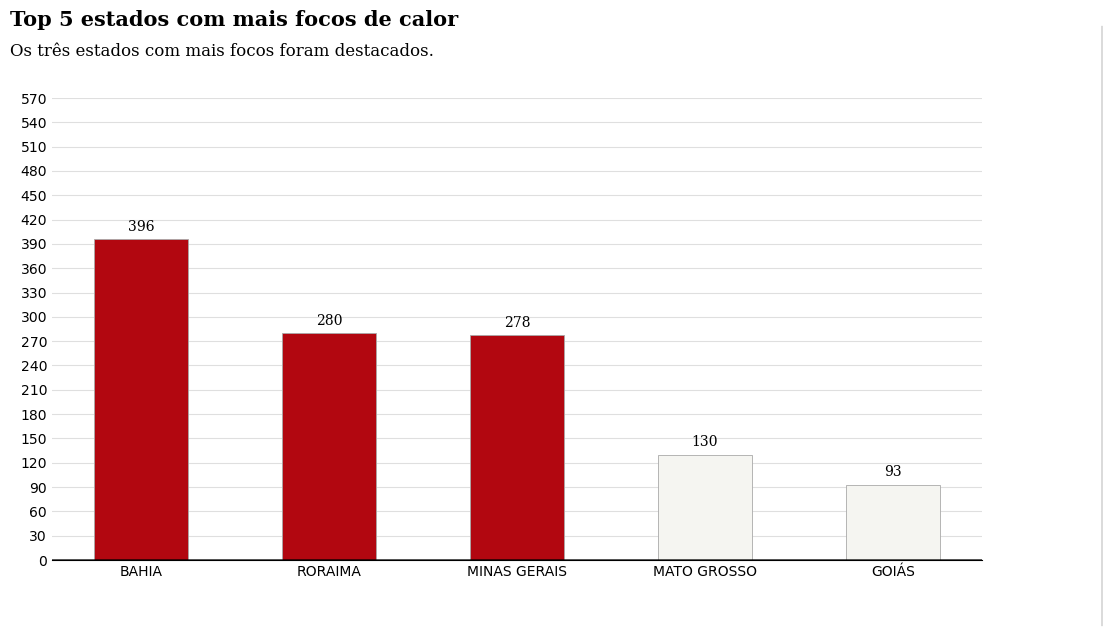

In [103]:
# data
data = df.groupby('estado')['count'].sum().sort_values(ascending=False)[:5]

# plot
color_map = ["#f5f5f1" for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] = "#b20710"  # color highlight

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    data.index, data, width=0.5, edgecolor="darkgray", linewidth=0.6, color=color_map
)

# annotations
for i in data.index:
    ax.annotate(
        f"{data[i]}",
        xy=(i, data[i] + 15),
        va="center",
        ha="center",
        fontweight="light",
        fontfamily="serif",
    )

# remove border from plot
for s in ["top", "left", "right"]:
    ax.spines[s].set_visible(False)

# title and sub-title
fig.text(
    0.09,
    1,
    "Top 5 estados com mais focos de calor",
    fontsize=15,
    fontweight="bold",
    fontfamily="serif",
)
fig.text(
    0.09,
    0.95,
    "Os três estados com mais focos foram destacados.",
    fontsize=12,
    fontweight="light",
    fontfamily="serif",
)

ax.grid(axis="y", linestyle="-", alpha=0.4)

grid_y_ticks = np.arange(0, 600, 30)
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

# thicken the bottom line if you want to
plt.axhline(y=0, color="black", linewidth=1.3, alpha=0.7)

ax.tick_params(axis="both", which="major", labelsize=10)

import matplotlib.lines as lines

l1 = lines.Line2D(
    [1, 1], [0, 1], transform=fig.transFigure, figure=fig, color="black", lw=0.2
)
fig.lines.extend([l1])

ax.tick_params(axis="both", which="both", length=0)

plt.show()


Já na região nordeste do país, especialmente na Bahia, foram registradas áreas com alta temperatura que podem estar relacionadas a atividades industriais e ao uso de energia elétrica para refrigeração em períodos de calor intenso.

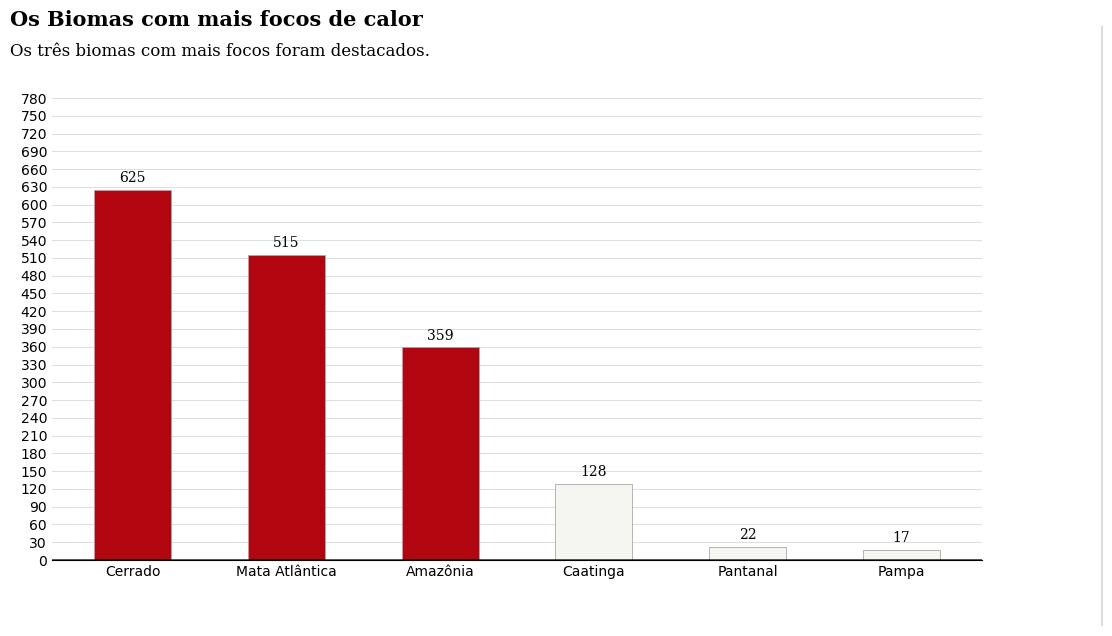

In [104]:
# data
data = df.groupby('bioma')['count'].sum().sort_values(ascending=False)[:10]

# plot
color_map = ["#f5f5f1" for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] = "#b20710"  # color highlight

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    data.index, data, width=0.5, edgecolor="darkgray", linewidth=0.6, color=color_map
)

# annotations
for i in data.index:
    ax.annotate(
        f"{data[i]}",
        xy=(i, data[i] + 20),
        va="center",
        ha="center",
        fontweight="light",
        fontfamily="serif",
    )

# remove border from plot
for s in ["top", "left", "right"]:
    ax.spines[s].set_visible(False)

# title and sub-title
fig.text(
    0.09,
    1,
    "Os Biomas com mais focos de calor",
    fontsize=15,
    fontweight="bold",
    fontfamily="serif",
)
fig.text(
    0.09,
    0.95,
    "Os três biomas com mais focos foram destacados.",
    fontsize=12,
    fontweight="light",
    fontfamily="serif",
)

ax.grid(axis="y", linestyle="-", alpha=0.4)

grid_y_ticks = np.arange(0, 800, 30)
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

# thicken the bottom line if you want to
plt.axhline(y=0, color="black", linewidth=1.3, alpha=0.7)

ax.tick_params(axis="both", which="major", labelsize=10)

import matplotlib.lines as lines

l1 = lines.Line2D(
    [1, 1], [0, 1], transform=fig.transFigure, figure=fig, color="black", lw=0.2
)
fig.lines.extend([l1])

ax.tick_params(axis="both", which="both", length=0)

plt.show()


Os biomas Cerrado e Mata Atlântica, em 01/04/2023, apresentaram a maior quantidade de focos de calor, ficando o bioma Amazônia em terceiro lugar. Isso pode ser explicado, muito provavelmente, pela maior densidade populacional e maior atividade industrial e agropecuária nas regiões desses biomas, o que pode indicar que fatores humanos ainda devem influenciar bastante a quantidade dessas fontes de calor.

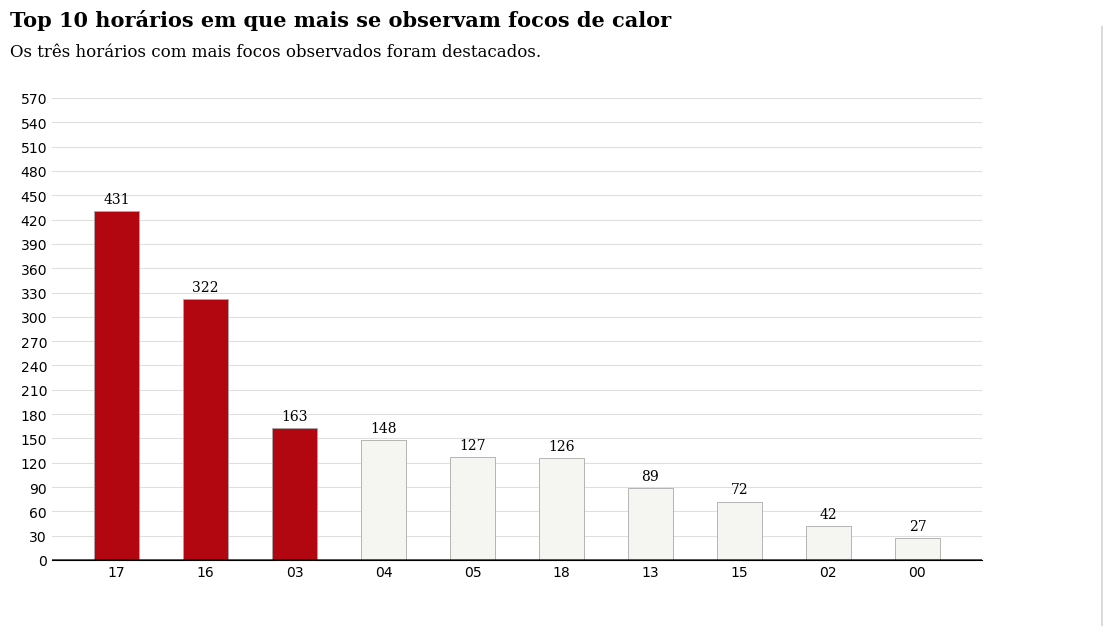

In [105]:
# data
data = df.groupby('hora_gmt')['count'].sum().sort_values(ascending=False)[:10]

# plot
color_map = ["#f5f5f1" for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] = "#b20710"  # color highlight

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    data.index, data, width=0.5, edgecolor="darkgray", linewidth=0.6, color=color_map
)

# annotations
for i in data.index:
    ax.annotate(
        f"{data[i]}",
        xy=(i, data[i] + 15),
        va="center",
        ha="center",
        fontweight="light",
        fontfamily="serif",
    )

# remove border from plot
for s in ["top", "left", "right"]:
    ax.spines[s].set_visible(False)

# title and sub-title
fig.text(
    0.09,
    1,
    "Top 10 horários em que mais se observam focos de calor",
    fontsize=15,
    fontweight="bold",
    fontfamily="serif",
)
fig.text(
    0.09,
    0.95,
    "Os três horários com mais focos observados foram destacados.",
    fontsize=12,
    fontweight="light",
    fontfamily="serif",
)

ax.grid(axis="y", linestyle="-", alpha=0.4)

grid_y_ticks = np.arange(0, 600, 30)
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

# thicken the bottom line if you want to
plt.axhline(y=0, color="black", linewidth=1.3, alpha=0.7)

ax.tick_params(axis="both", which="major", labelsize=10)

import matplotlib.lines as lines

l1 = lines.Line2D(
    [1, 1], [0, 1], transform=fig.transFigure, figure=fig, color="black", lw=0.2
)
fig.lines.extend([l1])

ax.tick_params(axis="both", which="both", length=0)

plt.show()


Observa-se acima que as fontes de calor nesse dia foram observadas principalmente no início da manhã e no final da tarde, tendo um pico de observação por volta das 17h. 

No geral, a visualização de dados sobre as fontes de calor observadas no Brasil em 01/04/2023 indica a existência de uma combinação de fatores naturais e humanos que contribuem para a geração de calor em diversas regiões do país. É importante monitorar essas fontes de calor e tomar medidas para reduzir sua intensidade e impacto sobre o meio ambiente e a saúde pública.